# Purpose

Explore the differences between the current geo-relevance definition compared to other approaches.

How many more subreddits do we gain by trying different definitions? Use some subreddits to check how geo-relevance definitions affect those subreddits.

2022-01-22 Update: 
queries in this EDA are now coming from temp tables so that the data doesn't shift over time. Reasons for shifts could happen because:
- Number of posts removed can change over time
- some snapshots of lookup tables expire after 30, 60, or 90 days (e.g., users_L7)



In [1]:
%load_ext autoreload
%autoreload 2

# Register bigquery magic
%load_ext google.cloud.bigquery

# Imports

## General imports

In [2]:
# Regular Imports
import os
from datetime import datetime

from google.cloud import bigquery

import plotly
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.io as pio
pio.renderers.default='notebook'

import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib_venn import venn2_unweighted, venn3_unweighted


os.environ['GOOGLE_CLOUD_PROJECT'] = 'data-prod-165221'

## `subclu` imports (custom module)

In [3]:
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric, reorder_array,
    get_venn_sets2,
)

setup_logging()
print_lib_versions([pd, np, sns, plotly])

python		v 3.7.11
===
pandas		v: 1.2.4
numpy		v: 1.19.5
seaborn		v: 0.11.1
plotly		v: 4.14.3


# Pull data from BigQuery

## Candidate subreddits & ambassador subreddits

In [4]:
%%time
%%bigquery df_candidate_subreddits --project data-science-prod-218515

SELECT *
FROM `reddit-employee-datasets.david_bermejo.subclu_subreddit_geo_candidates_posts_no_removed_20220122`

ORDER BY users_l7 DESC, posts_not_removed_l28 DESC

Downloading: 100%|███████████████████████████████████████████████████████████████████████████████| 326964/326964 [00:01<00:00, 215879.94rows/s]


CPU times: user 389 ms, sys: 187 ms, total: 575 ms
Wall time: 3.58 s


In [5]:
print(df_candidate_subreddits.shape)
df_candidate_subreddits.head(9)

(326964, 6)


,subreddit_name,subreddit_id,users_l7,posts_not_removed_l28,partition_date,successful_post_start_date
0,profile,t5_4vo55w,18843724,19,2022-01-22,2021-12-24
1,askreddit,t5_2qh1i,12688040,229399,2022-01-22,2021-12-24
2,antiwork,t5_2y77d,7268278,37518,2022-01-22,2021-12-24
3,pics,t5_2qh0u,7192964,19996,2022-01-22,2021-12-24
4,interestingasfuck,t5_2qhsa,5910293,4632,2022-01-22,2021-12-24
5,funny,t5_2qh33,5822445,10612,2022-01-22,2021-12-24
6,gaming,t5_2qh03,5689463,19448,2022-01-22,2021-12-24
7,tinder,t5_2w7mz,5326166,8522,2022-01-22,2021-12-24
8,news,t5_2qh3l,5190249,5211,2022-01-22,2021-12-24


In [6]:
# df_candidate_subreddits.to_csv('df_candidate_subreddits.csv', index=False)

## Ambassador subreddits

In [7]:
%%time
%%bigquery df_ambassador_subs --project data-science-prod-218515

SELECT
    c.users_l7
    , posts_not_removed_l28
    , amb.*
FROM `reddit-employee-datasets.david_bermejo.ambassador_subreddits_union_20211216` AS amb
LEFT JOIN `reddit-employee-datasets.david_bermejo.subclu_subreddit_geo_candidates_posts_no_removed_20220122` c
    ON amb.subreddit_id = c.subreddit_id
    
WHERE amb.subreddit_id IS NOT NULL

ORDER BY 1 DESC, 2 DESC

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████| 211/211 [00:01<00:00, 152.47rows/s]

CPU times: user 46.7 ms, sys: 11.8 ms, total: 58.6 ms
Wall time: 2.23 s


In [8]:
# df_ambassador_subs.to_csv('df_ambassador_subs', index=False)

In [9]:
print(df_ambassador_subs.shape)
df_ambassador_subs.head(9)

(211, 11)


,users_l7,posts_not_removed_l28,subreddit_id,subreddit_name,i18n_topic,i18n_type,i18n_country_code,i18n_owner,i18n_type_2,ambassador_or_default_sub_germany,ambassador_or_default_sub_france
0,569489.0,2328.0,t5_22i0,de,None,organic,DE,None,None,True,False
1,494186.0,6067.0,t5_37k29,ich_iel,None,organic,DE,None,None,True,False
2,303499.0,4441.0,t5_2qhjz,askfrance,None,ambassador,FR,None,community builders,False,True
3,152153.0,2663.0,t5_2r6ca,fragreddit,None,organic,DE,None,inactive,True,False
4,118382.0,700.0,t5_3ntp6,wasletztepreis,None,organic,DE,None,None,True,False
5,102322.0,576.0,t5_33hvw,beziehungen,Dating & Relationship,ambassador,DE,None,None,True,False
6,64604.0,1113.0,t5_2yjbi,minecraftfr,None,ambassador,FR,None,community builders,False,True
7,62318.0,62.0,t5_30305,de_iama,None,organic,DE,None,None,True,False
8,52236.0,84.0,t5_3jxvk,tja,Fun,ambassador,DE,None,None,True,False


## Default geo-relevance score

In [10]:
%%time
%%bigquery df_geo_baseline --project data-science-prod-218515 

-- default geo-relevance list
SELECT *
FROM `reddit-employee-datasets.david_bermejo.subclu_subreddit_geo_score_default_daily_20220122`
WHERE 1=1
    AND (
        country_name IN (
            'Germany', 'Austria', 'Switzerland', 'India', 'France', 'Brazil', 'Portugal', 'Italy',
            'Spain', 'Mexico', 'Argentina', 'Chile'
        )
        -- OR geo_region = 'LATAM' -- LATAM is noisy, focus on top countries instead
        -- eng-i18n =  Canada, UK, Australia
        OR geo_country_code IN ('CA', 'GB', 'AU')
    )
;

Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████| 13342/13342 [00:01<00:00, 12246.23rows/s]

CPU times: user 61.8 ms, sys: 27.1 ms, total: 88.9 ms
Wall time: 1.83 s


In [11]:
# df_geo_baseline.to_csv('df_geo_baseline.csv', index=False)

In [12]:
print(df_geo_baseline.shape)
df_geo_baseline.head(7)

(13342, 10)


,rating_short,rating_name,primary_topic,subreddit_name,subreddit_id,geo_country_code,country_name,geo_region,users_l7,posts_not_removed_l28
0,E,Everyone,Politics,chile,t5_2rer8,CL,Chile,LATAM,70411,1779
1,X,Sexually Explicit,Mature Themes and Adult Content,chilenasnsfw,t5_3qjtp2,CL,Chile,LATAM,29072,502
2,E,Everyone,Mature Themes and Adult Content,icatasalazar,t5_4g8sts,CL,Chile,LATAM,27130,149
3,X,Sexually Explicit,None,vaimonroe,t5_2o4s5p,CL,Chile,LATAM,16040,78
4,E,Everyone,Funny/Humor,moaigreddit,t5_2rks8q,CL,Chile,LATAM,12947,570
5,E,Everyone,Internet Culture and Memes,aweonasogang,t5_2v7upg,CL,Chile,LATAM,10555,391
6,E,Everyone,Place,republicadechile,t5_qjv65,CL,Chile,LATAM,10436,215


## New geo-relevance scores, L14 days

1. % of subreddit, lower threshold 
2. % of country DAU

In [149]:
%%time
%%bigquery df_geo_new --project data-science-prod-218515

-- Select subs with new definition (16% from L14 days + % by COUNTRY)
DECLARE MIN_POSTS_L28_NOT_REMOVED NUMERIC DEFAULT 4;

-- All other i18n countries
--  From these, only India is expected to have a large number of English-language subreddits
--  Some i18n subs (like 1fcnuernberg) are only really active once a week b/c of game schedule
--   so they have few posts, but many comments. Add post + comment filter instead of only post
DECLARE min_users_geo_l7 NUMERIC DEFAULT 45;

SELECT * EXCEPT(views_dt_start, views_dt_end, pt)  -- , posts_not_removed_l28, users_l7
FROM `reddit-employee-datasets.david_bermejo.subclu_subreddit_geo_score_pct_of_country_20220122` as geo
WHERE
    posts_not_removed_l28 >= MIN_POSTS_L28_NOT_REMOVED
    AND users_l7 >= min_users_geo_l7
    AND (
        country_name IN (
            'Germany', 'Austria', 'Switzerland', 'India', 'France', 'Spain', 'Brazil', 'Portugal', 'Italy',
            'Mexico', 'Argentina', 'Chile',
            'United States'  # use U.S. as control check
        )
        -- OR geo_region = 'LATAM' -- LATAM is noisy, focus on top countries instead
        -- eng-i18n =  Canada, UK, Australia
        OR geo_country_code IN ('CA', 'GB', 'AU')
    )
ORDER BY users_l7 DESC, subreddit_name
;

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████| 1000710/1000710 [00:03<00:00, 251899.03rows/s]


CPU times: user 995 ms, sys: 691 ms, total: 1.69 s
Wall time: 12.6 s


In [150]:
# df_geo_new.to_csv('df_geo_new.csv', index=False)

In [151]:
print(df_geo_new.shape)
df_geo_new.head(7)

(1000710, 15)


,posts_not_removed_l28,users_l7,subreddit_name,subreddit_id,geo_country_code,country_name,geo_region,users_percent_by_country,users_percent_by_subreddit,users_in_subreddit_from_country,total_users_in_country,total_users_in_subreddit,over_18,verdict,type
0,19,18843724,profile,t5_4vo55w,MX,Mexico,LATAM,0.341157,0.018834,2938865,8614400,156037588,None,None,public
1,19,18843724,profile,t5_4vo55w,AT,Austria,EMEA,0.318590,0.005355,835537,2622613,156037588,None,None,public
2,19,18843724,profile,t5_4vo55w,DE,Germany,EMEA,0.317515,0.048288,7534687,23730177,156037588,None,None,public
3,19,18843724,profile,t5_4vo55w,GB,United Kingdom,EMEA,0.284319,0.080967,12633831,44435368,156037588,None,None,public
4,19,18843724,profile,t5_4vo55w,BR,Brazil,LATAM,0.267550,0.024906,3886201,14525140,156037588,None,None,public
5,19,18843724,profile,t5_4vo55w,CL,Chile,LATAM,0.255446,0.003785,590579,2311951,156037588,None,None,public
6,19,18843724,profile,t5_4vo55w,CH,Switzerland,EMEA,0.251405,0.004440,692828,2755829,156037588,None,None,public


## Language by country
e.g., % of posts by detected language per country

In [16]:
%%time
%%bigquery df_language_by_country --project data-science-prod-218515 

-- Select language for target i18n countries
SELECT * 
FROM `reddit-employee-datasets.david_bermejo.subclu_posts_primary_language_by_country_20220122` as geo
WHERE 1=1
    AND (
        geolocation_country_name IN (
            'Germany', 'Austria', 'Switzerland', 'India', 'France', 'Spain', 'Brazil', 'Portugal', 'Italy',
            'Mexico', 'Argentina', 'Chile',
            'Canada', 'Australia', 'United Kingdom'
        )
    )
ORDER BY geolocation_country_name ASC, language_rank ASC
;

Downloading: 100%|████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 113.41rows/s]

CPU times: user 42.8 ms, sys: 10.6 ms, total: 53.4 ms
Wall time: 2.03 s


In [17]:
# df_language_by_country.to_csv('df_language_by_country.csv', index=False)

In [18]:
print(df_language_by_country.shape)
df_language_by_country.head(7)

(150, 10)


,geolocation_country_name,weighted_language,thing_type,total_count,language_count,language_percent,language_rank,language_name,language_name_top_only,language_in_use_multilingual
0,Argentina,en,post,103033,63372,0.615065,1,English,English,True
1,Argentina,es,post,103033,13387,0.129929,2,Spanish,Spanish,True
2,Argentina,UNKNOWN,post,103033,1631,0.015830,3,Unknown,Unknown,False
3,Argentina,la,post,103033,1128,0.010948,4,Latin,Other_language,False
4,Argentina,gl,post,103033,1092,0.010599,5,Galician,Other_language,False
5,Argentina,ca,post,103033,1088,0.010560,6,Catalan,Catalan,False
6,Argentina,it,post,103033,861,0.008357,7,Italian,Italian,True


## Language per subreddit

rank & % of posts per language, by subreddit

In [170]:
%%time
%%bigquery df_lang_by_subreddit --project data-science-prod-218515

-- Select only subreddits that have target language as primary or 2ndary language
WITH
    subreddits_with_target_languages AS (
        SELECT
            DISTINCT(subreddit_id) as subreddit_id
        FROM `reddit-employee-datasets.david_bermejo.subclu_posts_primary_language_by_subreddit_20220122` as geo
        WHERE
            subreddit_name IN (
                'formula1', 'rugbyunion', 'rugbyaustralia',
                'europe'
            )
            OR (
                (
                    language_rank = 1
                    OR language_rank = 2
                )
                AND language_name IN (
                    -- exclude English for now b/c it's most subreddits
                    -- 'English', 
                    'German', 
                    'French', 'Italian',
                    'Spanish', 'Portuguese',

                    -- Languages in India
                    'Hindi',
                    'Marathi',
                    'Tamil',
                    'Telugu',
                    'Malayalam'
                )
            )
    )


SELECT geo.*
FROM subreddits_with_target_languages sel
    LEFT JOIN `reddit-employee-datasets.david_bermejo.subclu_posts_primary_language_by_subreddit_20220122` AS geo
        ON sel.subreddit_id = geo.subreddit_id

WHERE
    language_rank <= 3
ORDER BY subreddit_name ASC, language_rank ASC
;

Downloading: 100%|██████████████████████████████████████████████████████████████████████████████████| 51633/51633 [00:01<00:00, 39517.31rows/s]

CPU times: user 120 ms, sys: 44.9 ms, total: 165 ms
Wall time: 5.43 s


In [171]:
# df_lang_by_subreddit.to_csv('df_lang_by_subreddit.csv', index=False)

In [172]:
print(df_lang_by_subreddit.shape)
df_lang_by_subreddit.head(7)

(51633, 14)


,rating_short,rating_name,primary_topic,subreddit_id,subreddit_name,weighted_language,thing_type,total_count,language_count,language_percent,language_rank,language_name,language_name_top_only,language_in_use_multilingual
0,None,None,None,t5_3cakx7,00fluffnstuff,en,post,41,23,0.560976,1,English,English,True
1,None,None,None,t5_3cakx7,00fluffnstuff,de,post,41,5,0.121951,2,German,German,True
2,None,None,None,t5_3cakx7,00fluffnstuff,lb,post,41,3,0.073171,3,Luxembourgish,Other_language,False
3,None,None,None,t5_4byrct,0nlyfantastic0,pt,post,13,7,0.538462,1,Portuguese,Portuguese,True
4,None,None,None,t5_4byrct,0nlyfantastic0,en,post,13,2,0.153846,2,English,English,True
5,None,None,None,t5_4byrct,0nlyfantastic0,es,post,13,1,0.076923,3,Spanish,Spanish,True
6,E,Everyone,Crypto,t5_5mmp3x,1000xcryptogems,en,post,34,33,0.970588,1,English,English,True


# Data overview

## Why 45 & 4 posts?

About half of all subreddits with 1+ users & 1+ posts (not removed) have 45+ users & 4+ posts.

But only 36.2% of subreddits have BOTH 45+ users AND 4+ posts not removed.

- Only about half of the ambassador or hand-picked subreddits are above this threshold.
- Most ambassador/default subs are no longer active

In [22]:
df_candidate_subreddits.shape

(326964, 6)

In [52]:
df_candidate_subreddits['users_l7_bins'] = pd.cut(
    df_candidate_subreddits['users_l7'],
    bins=[0, 44.999, df_candidate_subreddits['users_l7'].max()],
    labels=['00 to 44', '45+']
).astype(str)

df_candidate_subreddits['posts_not_removed_l28_bins'] = pd.cut(
    df_candidate_subreddits['posts_not_removed_l28'],
    bins=[0, 3.999, df_candidate_subreddits['posts_not_removed_l28'].max()],
    labels=['0 to 3', '04+']
).astype(str)

In [60]:
value_counts_and_pcts(
    df_candidate_subreddits['users_l7_bins'],
    count_type='subreddits',
    reset_index=True,
    add_col_prefix=False,
    cumsum=False
)

,users_l7_bins,subreddits_count,percent_of_subreddits
0,00 to 44,"172,088",52.6%
1,45+,"154,876",47.4%


In [59]:
value_counts_and_pcts(
    df_candidate_subreddits['posts_not_removed_l28_bins'],
    count_type='subreddits',
    reset_index=True,
    add_col_prefix=False,
    cumsum=False
)

,posts_not_removed_l28_bins,subreddits_count,percent_of_subreddits
0,04+,"166,080",50.8%
1,0 to 3,"160,884",49.2%


In [62]:
value_counts_and_pcts(
    df_candidate_subreddits,
    ['users_l7_bins', 'posts_not_removed_l28_bins'],
    count_type='subreddits',
    sort_index=True,
#     reset_index=True,
    add_col_prefix=False,
    cumsum=False
)

In [75]:
style_df_numeric(
    df_candidate_subreddits[['users_l7', 'posts_not_removed_l28']].fillna(0)
    .describe(
#         percentiles=[.1, .25, .472, .5, .527, .75, .9]
    ).T,
    float_round=1,
#     pct_cols=['mean', 'min', '25%', '50%', '75%', 'max'],
    pct_digits=3,
)

,count,mean,std,min,25%,50%,75%,max
users_l7,"326,964","4,052.1","72,131.9",1.0,4.0,35.0,363.0,"18,843,724.0"
posts_not_removed_l28,"326,964",88.6,"1,262.0",1.0,1.0,4.0,15.0,"326,209.0"


In [40]:
# value_counts_and_pcts(
#     pd.cut(df_candidate_subreddits['users_l7'], bins=10).astype(str)
# )

In [64]:
mask_amb_no_users = df_ambassador_subs['users_l7'].isnull()

style_df_numeric(
    df_ambassador_subs[['users_l7', 'posts_not_removed_l28']].fillna(0)
    .describe(
        # percentiles=[.1, .25, .475, .5, .525, .75, .9]
    ).T,
    float_round=2,
    # pct_cols=['mean', 'min', '25%', '50%', '75%', 'max'],
    pct_digits=3,
)

,count,mean,std,min,25%,50%,75%,max
users_l7,211,"11,577.12","57,840.34",0.00,0.00,58.00,999.50,"569,489.00"
posts_not_removed_l28,211,120.06,578.09,0.00,0.00,3.00,34.50,"6,067.00"


In [65]:
style_df_numeric(
    df_ambassador_subs[['users_l7', 'posts_not_removed_l28']]
    .describe(percentiles=[.1, .25, .475, .5, .525, .75, .9]).T,
    float_round=2,
    # pct_cols=['mean', 'min', '25%', '50%', '75%', 'max'],
    pct_digits=3,
)

,count,mean,std,min,10%,25%,47.5%,50%,52.5%,75%,90%,max
users_l7,122,"20,022.73","75,071.61",1.00,31.30,114.25,479.85,537.00,675.62,"6,606.25","34,738.60","569,489.00"
posts_not_removed_l28,122,207.64,749.44,1.00,2.00,5.00,20.00,22.00,27.58,83.50,388.50,"6,067.00"


In [76]:
# %%time
# fig = px.box(
#     df_candidate_subreddits,
#     y='users_l7',
#     log_y=True,
#     points='outliers',
# )
# fig.show()

In [73]:
# %%time
# ax = sns.boxenplot(
#     x=df_candidate_subreddits.sample(n=10000, random_state=42)
#     ["users_l7"]
# )
# ax.set(xscale="log")
# plt.show()

Tried a few other plots, but those were not helpful, noisy, or would take too long to compute

In [ ]:
# fig = px.histogram(
#     df_candidate_subreddits[df_candidate_subreddits['users_l7'] <= 20000000], 
#     x="users_l7",
#     log_x=True,
#     # marginal="rug",
# )
# fig.show()

# fig = px.violin(
#     df_candidate_subreddits.sample(n=2000, random_state=42),
#     y='users_l7',
#     box=True,
#     points=False,
#     # log_y=True,
# )
# fig.show()

In [ ]:
# %%time
# ax = sns.displot(
#     df_candidate_subreddits[df_candidate_subreddits['users_l7'] <= 2000000].sample(n=1000, random_state=42), 
#     x="users_l7",
#     # kde=True
# )
# ax.set(xscale="log")

# A) % by subreddit, daily [default @ 40%]

This default also limits to only subreddits with 100+ users L7.

In [78]:
df_geo_baseline.head()

,rating_short,rating_name,primary_topic,subreddit_name,subreddit_id,geo_country_code,country_name,geo_region,users_l7,posts_not_removed_l28
0,E,Everyone,Politics,chile,t5_2rer8,CL,Chile,LATAM,70411,1779
1,X,Sexually Explicit,Mature Themes and Adult Content,chilenasnsfw,t5_3qjtp2,CL,Chile,LATAM,29072,502
2,E,Everyone,Mature Themes and Adult Content,icatasalazar,t5_4g8sts,CL,Chile,LATAM,27130,149
3,X,Sexually Explicit,None,vaimonroe,t5_2o4s5p,CL,Chile,LATAM,16040,78
4,E,Everyone,Funny/Humor,moaigreddit,t5_2rks8q,CL,Chile,LATAM,12947,570


In [79]:

style_df_numeric(
    df_geo_baseline[['users_l7', 'posts_not_removed_l28']].fillna(0)
    .describe(
        # percentiles=[.1, .25, .475, .5, .525, .75, .9]
    ).T,
    float_round=2,
    # pct_cols=['mean', 'min', '25%', '50%', '75%', 'max'],
    pct_digits=3,
)

,count,mean,std,min,25%,50%,75%,max
users_l7,"13,342","4,292.96","29,865.41",100.00,187.00,479.00,"1,753.75","1,575,568.00"
posts_not_removed_l28,"13,342",122.20,685.13,4.00,8.00,18.00,54.00,"30,225.00"


In [80]:
counts_describe(
    df_geo_baseline[['subreddit_id', 'country_name']]
)

,dtype,count,unique,unique-percent,null-count,null-percent
subreddit_id,object,"13,342","12,355",92.60%,0,0.00%
country_name,object,"13,342",15,0.11%,0,0.00%


# B) % by subreddit, L28 [lower threshold] & C) % by country, L28

These are in the same table/query, so we can do a quick check of them together.

First make sure that all of these subs are above users & activity threshold

In [93]:
style_df_numeric(
    df_geo_new[['users_l7', 'posts_not_removed_l28',]].fillna(0)
    .describe(
        # percentiles=[.1, .25, .475, .5, .525, .75, .9]
    ).T,
    float_round=2,
    # pct_cols=['mean', 'min', '25%', '50%', '75%', 'max'],
    pct_digits=3,
)

,count,mean,std,min,25%,50%,75%,max
users_l7,"921,745","15,842.38","162,056.73",45.00,293.00,"1,065.00","4,104.00","18,843,724.00"
posts_not_removed_l28,"921,745",243.46,"1,995.28",4.00,12.00,33.00,117.00,"326,209.00"


In [81]:
df_geo_new.head()

,posts_not_removed_l28,users_l7,subreddit_name,subreddit_id,geo_country_code,country_name,geo_region,users_percent_by_country,users_percent_by_subreddit,users_in_subreddit_from_country,total_users_in_country,total_users_in_subreddit,over_18,verdict,type
0,19,18843724,profile,t5_4vo55w,MX,Mexico,LATAM,0.341157,0.018834,2938865,8614400,156037588,None,None,public
1,19,18843724,profile,t5_4vo55w,AT,Austria,EMEA,0.318590,0.005355,835537,2622613,156037588,None,None,public
2,19,18843724,profile,t5_4vo55w,DE,Germany,EMEA,0.317515,0.048288,7534687,23730177,156037588,None,None,public
3,19,18843724,profile,t5_4vo55w,GB,United Kingdom,EMEA,0.284319,0.080967,12633831,44435368,156037588,None,None,public
4,19,18843724,profile,t5_4vo55w,BR,Brazil,LATAM,0.267550,0.024906,3886201,14525140,156037588,None,None,public


create df with previous definition @ 16% of users

In [91]:
df_geo_16_pct_l28 = (
    df_geo_new[df_geo_new['users_percent_by_subreddit'] >= 0.16]
    .copy()
)
df_geo_16_pct_l28.shape

(10490, 15)

In [83]:
counts_describe(
    df_geo_new[['subreddit_id', 'country_name']]
)

,dtype,count,unique,unique-percent,null-count,null-percent
subreddit_id,object,"921,745","78,567",8.52%,0,0.00%
country_name,object,"921,745",15,0.00%,0,0.00%


In [92]:
counts_describe(
    df_geo_16_pct_l28[['subreddit_id', 'country_name']]
)

,dtype,count,unique,unique-percent,null-count,null-percent
subreddit_id,object,"10,490","10,169",96.94%,0,0.00%
country_name,object,"10,490",15,0.14%,0,0.00%


In [94]:
style_df_numeric(
    df_geo_new[['users_percent_by_country', 'users_percent_by_subreddit',
               ]].fillna(0)
    .describe(
        # percentiles=[.1, .25, .475, .5, .525, .75, .9]
    ).T,
    float_round=2,
    pct_cols=['mean', 'min', '25%', '50%', '75%', 'max'],
    pct_digits=3,
)

,count,mean,std,min,25%,50%,75%,max
users_percent_by_country,"921,745",0.012%,0.00,0.000%,0.000%,0.000%,0.002%,39.650%
users_percent_by_subreddit,"921,745",2.552%,0.07,0.002%,0.356%,0.877%,2.765%,100.000%


In [89]:
style_df_numeric(
    df_geo_new[['users_percent_by_country',
               ]].fillna(0)
    .describe(
        percentiles=[.1, .25, .5, .75, .8, .9, .95]
    ).T,
    float_round=2,
    pct_labels='%',
    pct_cols=['mean', 'min', 'max'],
    pct_digits=5,
)

,count,mean,std,min,10%,25%,50%,75%,80%,90%,95%,max
users_percent_by_country,"921,745",0.01245%,0.00,0.00001%,0.00005%,0.00013%,0.00044%,0.00199%,0.00302%,0.00974%,0.02682%,39.65034%


# D) Primary language, posts L28

Here we're checking rank 1 & rank 2, we' set the threshold for rank 1 (primary) after exploration.

In [134]:
df_lang_by_subreddit.shape

(51624, 14)

In [135]:
df_candidate_subreddits.head()

,subreddit_name,subreddit_id,users_l7,posts_not_removed_l28,partition_date,successful_post_start_date,users_l7_bins,posts_not_removed_l28_bins
0,profile,t5_4vo55w,18843724,19,2022-01-22,2021-12-24,45+,04+
1,askreddit,t5_2qh1i,12688040,229399,2022-01-22,2021-12-24,45+,04+
2,antiwork,t5_2y77d,7268278,37518,2022-01-22,2021-12-24,45+,04+
3,pics,t5_2qh0u,7192964,19996,2022-01-22,2021-12-24,45+,04+
4,interestingasfuck,t5_2qhsa,5910293,4632,2022-01-22,2021-12-24,45+,04+


In [152]:
style_df_numeric(
    df_lang_by_subreddit.merge(
        df_candidate_subreddits[['subreddit_id', 'users_l7', 'posts_not_removed_l28',]],
        how='left',
        on=['subreddit_id']
    )
    [['users_l7', 'posts_not_removed_l28',]].fillna(0)
    .describe(
        # percentiles=[.1, .25, .475, .5, .525, .75, .9]
    ).T,
    float_round=2,
    # pct_labels='%',
    # pct_cols=['mean', 'min', 'max'],
    pct_digits=3,
)

,count,mean,std,min,25%,50%,75%,max
users_l7,"51,624","12,615.87","109,322.64",45.00,237.00,921.00,"3,819.00","7,192,964.00"
posts_not_removed_l28,"51,624",270.01,"3,122.11",4.00,12.00,31.00,113.00,"326,209.00"


In [137]:
counts_describe(
    df_lang_by_subreddit[['subreddit_id', 'language_name']]
)

,dtype,count,unique,unique-percent,null-count,null-percent
subreddit_id,object,"51,624","18,188",35.23%,0,0.00%
language_name,object,"51,543",93,0.18%,81,0.16%


# Sanity checks

## Check specific subreddits

In [173]:
l_subs_to_check1 = [
    'cricket',
    # 'formula1',
    'rugbyunion',
    'rugbyaustralia',
]
l_subs_to_check2 = [
    'bundesliga',
    'premierleague',
    'ligue1',
    'laliga',
]

l_subs_to_check3 = [
    'ligamx',
    'seriea', 
    # 'soccer',
]

In [174]:
l_cols_base_disp_check = [
    'subreddit_id',
    'subreddit_name',
    'geo_country_code',
    'country_name',
    'users_l7',
    'posts_not_removed_l28',
]
l_cols_geo_new_disp_check = [
    'subreddit_name',
    'country_name',
    'users_percent_by_country',
    'users_percent_by_subreddit',
    'users_in_subreddit_from_country',
    'total_users_in_country',
    'total_users_in_subreddit',
]
l_cols_lang_disp_check = [
    'subreddit_id',
    'subreddit_name',
    'language_name',
    'language_percent',
    'language_rank',
    'language_count',
    'weighted_language',

    # 'langauge_in_use_multilingual',
]

In [179]:
def show_geo_score_for_sub(
    subreddit: str,
    top_n_pct_subreddit: int = 5,
    top_n_pct_country: int = 5,
) -> None:
    sub_ = subreddit
    """display geo-relevance scores for input sub"""
    print(f"\n\n=== Subreddit: {sub_} ===")
    print(f"Geo-relevance default [40% users in subreddit, daily]")
    display(
        style_df_numeric(
            df_geo_baseline[df_geo_baseline['subreddit_name'] == sub_]
            [l_cols_base_disp_check],
            rename_cols_for_display=True,
            int_cols=False,
        ).hide_index()
    )
    print(f"\nTop languages, by post [L28]") 
    display(
        style_df_numeric(
            df_lang_by_subreddit[df_lang_by_subreddit['subreddit_name'] == sub_]
            .sort_values(by=['language_rank'], ascending=True)
            [l_cols_lang_disp_check]
            .head(5),
            rename_cols_for_display=True,
            int_cols=False,
            l_bar_simple=['users_percent_by_subreddit', 'users_percent_by_country'],
        ).hide_index()
    )
    print(f"\nTop by % of subreddit [L28]")
    display(
        style_df_numeric(
            df_geo_new[df_geo_new['subreddit_name'] == sub_]
            .sort_values(by=['users_percent_by_subreddit'], ascending=False)
            [l_cols_geo_new_disp_check]
            .head(top_n_pct_subreddit),
            rename_cols_for_display=True,
            int_cols=False,
            l_bar_simple=['users_percent_by_subreddit', 'users_percent_by_country'],
        ).hide_index()
    )
    print(f"\nTop by % of country [L28]") 
    display(
        style_df_numeric(
            df_geo_new[df_geo_new['subreddit_name'] == sub_]
            .sort_values(by=['users_percent_by_country'], ascending=False)
            [l_cols_geo_new_disp_check]
            .head(top_n_pct_country),
            rename_cols_for_display=True,
            int_cols=False,
            pct_digits=3,
            l_bar_simple=['users_percent_by_subreddit', 'users_percent_by_country'],
        ).hide_index()
    )


In [180]:
show_geo_score_for_sub(
    'formula1',
    top_n_pct_subreddit=9,
    top_n_pct_country=9,
)



=== Subreddit: formula1 ===
Geo-relevance default [40% users in subreddit, daily]


subreddit id,subreddit name,geo country code,country name,users l7,posts not removed l28



Top languages, by post [L28]


subreddit id,subreddit name,language name,language percent,language rank,language count,weighted language
t5_2qimj,formula1,English,77.76%,1,"2,552",en
t5_2qimj,formula1,Norwegian,1.55%,2,51,no
t5_2qimj,formula1,Italian,1.34%,3,44,it



Top by % of subreddit [L28]


subreddit name,country name,users percent by country,users percent by subreddit,users in subreddit from country,total users in country,total users in subreddit
formula1,United States,1.00%,31.40%,"2,965,479","295,349,042","9,444,134"
formula1,United Kingdom,3.14%,14.75%,"1,393,358","44,435,368","9,444,134"
formula1,Canada,1.57%,6.88%,"649,998","41,410,610","9,444,134"
formula1,Australia,2.12%,4.77%,"450,159","21,212,020","9,444,134"
formula1,Germany,1.84%,4.62%,"436,359","23,730,177","9,444,134"
formula1,India,1.37%,2.59%,"244,168","17,881,562","9,444,134"
formula1,France,1.13%,1.35%,"127,474","11,275,674","9,444,134"
formula1,Italy,1.32%,1.02%,"96,378","7,283,606","9,444,134"
formula1,Portugal,3.56%,1.00%,"94,676","2,657,942","9,444,134"



Top by % of country [L28]


subreddit name,country name,users percent by country,users percent by subreddit,users in subreddit from country,total users in country,total users in subreddit
formula1,Portugal,3.562%,1.002%,"94,676","2,657,942","9,444,134"
formula1,United Kingdom,3.136%,14.754%,"1,393,358","44,435,368","9,444,134"
formula1,Austria,2.883%,0.801%,"75,623","2,622,613","9,444,134"
formula1,Switzerland,2.234%,0.652%,"61,575","2,755,829","9,444,134"
formula1,Australia,2.122%,4.767%,"450,159","21,212,020","9,444,134"
formula1,Germany,1.839%,4.620%,"436,359","23,730,177","9,444,134"
formula1,Canada,1.570%,6.883%,"649,998","41,410,610","9,444,134"
formula1,Spain,1.434%,0.934%,"88,162","6,148,262","9,444,134"
formula1,India,1.365%,2.585%,"244,168","17,881,562","9,444,134"


In [181]:
show_geo_score_for_sub(
    'soccer',
    top_n_pct_subreddit=11,
    top_n_pct_country=11,
)



=== Subreddit: soccer ===
Geo-relevance default [40% users in subreddit, daily]


subreddit id,subreddit name,geo country code,country name,users l7,posts not removed l28



Top languages, by post [L28]


subreddit id,subreddit name,language name,language percent,language rank,language count,weighted language
t5_2qi58,soccer,English,62.39%,1,"4,508",en
t5_2qi58,soccer,Italian,2.60%,2,188,it
t5_2qi58,soccer,German,1.95%,3,141,de



Top by % of subreddit [L28]


subreddit name,country name,users percent by country,users percent by subreddit,users in subreddit from country,total users in country,total users in subreddit
soccer,United States,0.87%,27.10%,"2,578,911","295,349,042","9,517,594"
soccer,United Kingdom,4.19%,19.55%,"1,860,886","44,435,368","9,517,594"
soccer,Canada,1.21%,5.27%,"501,130","41,410,610","9,517,594"
soccer,Germany,1.62%,4.04%,"384,149","23,730,177","9,517,594"
soccer,Australia,1.66%,3.70%,"351,833","21,212,020","9,517,594"
soccer,India,1.77%,3.33%,"317,157","17,881,562","9,517,594"
soccer,Portugal,6.09%,1.70%,"161,978","2,657,942","9,517,594"
soccer,France,1.07%,1.26%,"120,313","11,275,674","9,517,594"
soccer,Brazil,0.68%,1.03%,"98,349","14,525,140","9,517,594"
soccer,Italy,1.17%,0.90%,"85,294","7,283,606","9,517,594"



Top by % of country [L28]


subreddit name,country name,users percent by country,users percent by subreddit,users in subreddit from country,total users in country,total users in subreddit
soccer,Portugal,6.094%,1.702%,"161,978","2,657,942","9,517,594"
soccer,United Kingdom,4.188%,19.552%,"1,860,886","44,435,368","9,517,594"
soccer,Austria,2.074%,0.571%,"54,387","2,622,613","9,517,594"
soccer,Switzerland,1.998%,0.579%,"55,070","2,755,829","9,517,594"
soccer,India,1.774%,3.332%,"317,157","17,881,562","9,517,594"
soccer,Australia,1.659%,3.697%,"351,833","21,212,020","9,517,594"
soccer,Germany,1.619%,4.036%,"384,149","23,730,177","9,517,594"
soccer,Spain,1.338%,0.864%,"82,265","6,148,262","9,517,594"
soccer,Canada,1.210%,5.265%,"501,130","41,410,610","9,517,594"
soccer,Italy,1.171%,0.896%,"85,294","7,283,606","9,517,594"


In [178]:
show_geo_score_for_sub(
    'europe',
    top_n_pct_subreddit=11,
    top_n_pct_country=11,
)



=== Subreddit: europe ===
Geo-relevance default [40% users in subreddit, daily]


subreddit id,subreddit name,geo country code,country name,users l7,posts not removed l28



Top by % of subreddit [L28]


subreddit name,country name,users percent by country,users percent by subreddit,users in subreddit from country,total users in country,total users in subreddit
europe,United States,0.77%,28.12%,"2,282,750","295,349,042","8,119,063"
europe,United Kingdom,1.63%,8.91%,"723,512","44,435,368","8,119,063"
europe,Germany,3.03%,8.87%,"719,905","23,730,177","8,119,063"
europe,Canada,0.80%,4.08%,"330,877","41,410,610","8,119,063"
europe,France,2.32%,3.22%,"261,625","11,275,674","8,119,063"
europe,Italy,2.21%,1.98%,"160,782","7,283,606","8,119,063"
europe,Australia,0.69%,1.81%,"146,778","21,212,020","8,119,063"
europe,Portugal,4.48%,1.46%,"118,943","2,657,942","8,119,063"
europe,Spain,1.82%,1.38%,"112,130","6,148,262","8,119,063"
europe,Austria,4.11%,1.33%,"107,899","2,622,613","8,119,063"



Top by % of country [L28]


subreddit name,country name,users percent by country,users percent by subreddit,users in subreddit from country,total users in country,total users in subreddit
europe,Portugal,4.475%,1.465%,"118,943","2,657,942","8,119,063"
europe,Austria,4.114%,1.329%,"107,899","2,622,613","8,119,063"
europe,Germany,3.034%,8.867%,"719,905","23,730,177","8,119,063"
europe,France,2.320%,3.222%,"261,625","11,275,674","8,119,063"
europe,Switzerland,2.306%,0.783%,"63,561","2,755,829","8,119,063"
europe,Italy,2.207%,1.980%,"160,782","7,283,606","8,119,063"
europe,Spain,1.824%,1.381%,"112,130","6,148,262","8,119,063"
europe,United Kingdom,1.628%,8.911%,"723,512","44,435,368","8,119,063"
europe,Canada,0.799%,4.075%,"330,877","41,410,610","8,119,063"
europe,United States,0.773%,28.116%,"2,282,750","295,349,042","8,119,063"



Top languages, by post [L28]


subreddit id,subreddit name,language name,language percent,language rank,language count,weighted language
t5_2qh4j,europe,English,70.93%,1,"3,323",en
t5_2qh4j,europe,Danish,3.86%,2,181,da
t5_2qh4j,europe,Norwegian,2.60%,3,122,no


In [182]:
for sub_ in l_subs_to_check1:
    show_geo_score_for_sub(
        sub_,
        top_n_pct_subreddit=5,
        top_n_pct_country=5,
    )



=== Subreddit: cricket ===
Geo-relevance default [40% users in subreddit, daily]


subreddit id,subreddit name,geo country code,country name,users l7,posts not removed l28
t5_2qhe0,cricket,AU,Australia,"236,977","2,695"



Top languages, by post [L28]


subreddit id,subreddit name,language name,language percent,language rank,language count,weighted language
t5_2qhe0,cricket,English,83.70%,1,"2,254",en
t5_2qhe0,cricket,German,0.97%,2,26,de
t5_2qhe0,cricket,Luxembourgish,0.93%,3,25,lb



Top by % of subreddit [L28]


subreddit name,country name,users percent by country,users percent by subreddit,users in subreddit from country,total users in country,total users in subreddit
cricket,Australia,2.37%,29.97%,"501,970","21,212,020","1,674,737"
cricket,India,2.04%,21.79%,"364,975","17,881,562","1,674,737"
cricket,United States,0.09%,15.78%,"264,199","295,349,042","1,674,737"
cricket,United Kingdom,0.53%,14.17%,"237,314","44,435,368","1,674,737"
cricket,Canada,0.14%,3.46%,"57,955","41,410,610","1,674,737"



Top by % of country [L28]


subreddit name,country name,users percent by country,users percent by subreddit,users in subreddit from country,total users in country,total users in subreddit
cricket,Australia,2.366%,29.973%,"501,970","21,212,020","1,674,737"
cricket,India,2.041%,21.793%,"364,975","17,881,562","1,674,737"
cricket,United Kingdom,0.534%,14.170%,"237,314","44,435,368","1,674,737"
cricket,Canada,0.140%,3.461%,"57,955","41,410,610","1,674,737"
cricket,Switzerland,0.107%,0.176%,"2,951","2,755,829","1,674,737"




=== Subreddit: rugbyunion ===
Geo-relevance default [40% users in subreddit, daily]


subreddit id,subreddit name,geo country code,country name,users l7,posts not removed l28
t5_2qkbe,rugbyunion,GB,United Kingdom,"69,629","1,099"



Top languages, by post [L28]


subreddit id,subreddit name,language name,language percent,language rank,language count,weighted language
t5_2qkbe,rugbyunion,English,78.03%,1,856,en
t5_2qkbe,rugbyunion,Norwegian,1.46%,2,16,no
t5_2qkbe,rugbyunion,Danish,1.46%,3,16,da



Top by % of subreddit [L28]


subreddit name,country name,users percent by country,users percent by subreddit,users in subreddit from country,total users in country,total users in subreddit
rugbyunion,United Kingdom,0.56%,49.61%,"249,369","44,435,368","502,641"
rugbyunion,United States,0.02%,10.83%,"54,427","295,349,042","502,641"
rugbyunion,Australia,0.13%,5.66%,"28,470","21,212,020","502,641"
rugbyunion,Canada,0.04%,3.06%,"15,383","41,410,610","502,641"
rugbyunion,France,0.11%,2.55%,"12,842","11,275,674","502,641"



Top by % of country [L28]


subreddit name,country name,users percent by country,users percent by subreddit,users in subreddit from country,total users in country,total users in subreddit
rugbyunion,United Kingdom,0.561%,49.612%,"249,369","44,435,368","502,641"
rugbyunion,Australia,0.134%,5.664%,"28,470","21,212,020","502,641"
rugbyunion,France,0.114%,2.555%,"12,842","11,275,674","502,641"
rugbyunion,Switzerland,0.066%,0.360%,"1,809","2,755,829","502,641"
rugbyunion,Spain,0.044%,0.544%,"2,735","6,148,262","502,641"




=== Subreddit: rugbyaustralia ===
Geo-relevance default [40% users in subreddit, daily]


subreddit id,subreddit name,geo country code,country name,users l7,posts not removed l28
t5_3olov5,rugbyaustralia,AU,Australia,289,12
t5_3olov5,rugbyaustralia,GB,United Kingdom,289,12



Top languages, by post [L28]


subreddit id,subreddit name,language name,language percent,language rank,language count,weighted language
t5_3olov5,rugbyaustralia,English,58.33%,1,7,en
t5_3olov5,rugbyaustralia,Dutch,16.67%,2,2,nl
t5_3olov5,rugbyaustralia,None,8.33%,3,1,be



Top by % of subreddit [L28]


subreddit name,country name,users percent by country,users percent by subreddit,users in subreddit from country,total users in country,total users in subreddit
rugbyaustralia,Australia,0.00%,43.42%,666,"21,212,020","1,534"
rugbyaustralia,United Kingdom,0.00%,24.51%,376,"44,435,368","1,534"
rugbyaustralia,United States,0.00%,12.45%,191,"295,349,042","1,534"
rugbyaustralia,Canada,0.00%,2.87%,44,"41,410,610","1,534"
rugbyaustralia,Portugal,0.00%,0.91%,14,"2,657,942","1,534"



Top by % of country [L28]


subreddit name,country name,users percent by country,users percent by subreddit,users in subreddit from country,total users in country,total users in subreddit
rugbyaustralia,Australia,0.003%,43.416%,666,"21,212,020","1,534"
rugbyaustralia,United Kingdom,0.001%,24.511%,376,"44,435,368","1,534"
rugbyaustralia,Portugal,0.001%,0.913%,14,"2,657,942","1,534"
rugbyaustralia,Switzerland,0.000%,0.587%,9,"2,755,829","1,534"
rugbyaustralia,Spain,0.000%,0.522%,8,"6,148,262","1,534"


In [162]:
for sub_ in l_subs_to_check2:
    show_geo_score_for_sub(
        sub_,
        top_n_pct_subreddit=5,
        top_n_pct_country=5,
    )



=== Subreddit: bundesliga ===
Geo-relevance default [40% users in subreddit, daily]


subreddit id,subreddit name,geo country code,country name,users l7,posts not removed l28
t5_2s82y,bundesliga,DE,Germany,"15,956",117



Top by % of subreddit [L28]


subreddit name,country name,users percent by country,users percent by subreddit,users in subreddit from country,total users in country,total users in subreddit
bundesliga,Germany,0.22%,66.89%,"51,936","23,730,177","77,643"
bundesliga,United States,0.00%,11.91%,"9,244","295,349,042","77,643"
bundesliga,United Kingdom,0.01%,3.36%,"2,606","44,435,368","77,643"
bundesliga,Canada,0.00%,1.73%,"1,340","41,410,610","77,643"
bundesliga,Austria,0.04%,1.41%,"1,094","2,622,613","77,643"



Top by % of country [L28]


subreddit name,country name,users percent by country,users percent by subreddit,users in subreddit from country,total users in country,total users in subreddit
bundesliga,Germany,0.219%,66.891%,"51,936","23,730,177","77,643"
bundesliga,Austria,0.042%,1.409%,"1,094","2,622,613","77,643"
bundesliga,Switzerland,0.026%,0.923%,717,"2,755,829","77,643"
bundesliga,Portugal,0.008%,0.258%,200,"2,657,942","77,643"
bundesliga,United Kingdom,0.006%,3.356%,"2,606","44,435,368","77,643"



Top languages, by post [L28]


subreddit id,subreddit name,language name,language percent,language rank,language count,weighted language
t5_2s82y,bundesliga,English,44.44%,1,52,en
t5_2s82y,bundesliga,German,35.90%,2,42,de
t5_2s82y,bundesliga,French,4.27%,3,5,fr




=== Subreddit: premierleague ===
Geo-relevance default [40% users in subreddit, daily]


subreddit id,subreddit name,geo country code,country name,users l7,posts not removed l28



Top by % of subreddit [L28]


subreddit name,country name,users percent by country,users percent by subreddit,users in subreddit from country,total users in country,total users in subreddit
premierleague,United Kingdom,0.60%,29.29%,"267,805","44,435,368","914,478"
premierleague,United States,0.09%,28.53%,"260,883","295,349,042","914,478"
premierleague,Australia,0.22%,5.18%,"47,381","21,212,020","914,478"
premierleague,India,0.25%,4.82%,"44,055","17,881,562","914,478"
premierleague,Canada,0.10%,4.40%,"40,201","41,410,610","914,478"



Top by % of country [L28]


subreddit name,country name,users percent by country,users percent by subreddit,users in subreddit from country,total users in country,total users in subreddit
premierleague,United Kingdom,0.603%,29.285%,"267,805","44,435,368","914,478"
premierleague,India,0.246%,4.818%,"44,055","17,881,562","914,478"
premierleague,Australia,0.223%,5.181%,"47,381","21,212,020","914,478"
premierleague,Portugal,0.167%,0.487%,"4,449","2,657,942","914,478"
premierleague,Austria,0.115%,0.331%,"3,028","2,622,613","914,478"



Top languages, by post [L28]


subreddit id,subreddit name,language name,language percent,language rank,language count,weighted language
t5_2scup,premierleague,English,91.36%,1,782,en
t5_2scup,premierleague,French,2.57%,2,22,fr
t5_2scup,premierleague,Filipino,0.58%,3,5,fil




=== Subreddit: ligue1 ===
Geo-relevance default [40% users in subreddit, daily]


subreddit id,subreddit name,geo country code,country name,users l7,posts not removed l28
t5_2sc3j,ligue1,FR,France,"1,872",76



Top by % of subreddit [L28]


subreddit name,country name,users percent by country,users percent by subreddit,users in subreddit from country,total users in country,total users in subreddit
ligue1,France,0.04%,62.70%,"4,320","11,275,674","6,890"
ligue1,United States,0.00%,11.47%,790,"295,349,042","6,890"
ligue1,Canada,0.00%,4.66%,321,"41,410,610","6,890"
ligue1,United Kingdom,0.00%,3.96%,273,"44,435,368","6,890"
ligue1,Germany,0.00%,1.64%,113,"23,730,177","6,890"



Top by % of country [L28]


subreddit name,country name,users percent by country,users percent by subreddit,users in subreddit from country,total users in country,total users in subreddit
ligue1,France,0.038%,62.700%,"4,320","11,275,674","6,890"
ligue1,Switzerland,0.002%,0.885%,61,"2,755,829","6,890"
ligue1,Portugal,0.001%,0.319%,22,"2,657,942","6,890"
ligue1,Canada,0.001%,4.659%,321,"41,410,610","6,890"
ligue1,United Kingdom,0.001%,3.962%,273,"44,435,368","6,890"



Top languages, by post [L28]


subreddit id,subreddit name,language name,language percent,language rank,language count,weighted language
t5_2sc3j,ligue1,French,73.68%,1,56,fr
t5_2sc3j,ligue1,English,11.84%,2,9,en
t5_2sc3j,ligue1,Portuguese,3.95%,3,3,pt




=== Subreddit: laliga ===
Geo-relevance default [40% users in subreddit, daily]


subreddit id,subreddit name,geo country code,country name,users l7,posts not removed l28



Top by % of subreddit [L28]


subreddit name,country name,users percent by country,users percent by subreddit,users in subreddit from country,total users in country,total users in subreddit
laliga,United States,0.00%,33.44%,"2,163","295,349,042","6,469"
laliga,United Kingdom,0.00%,7.98%,516,"44,435,368","6,469"
laliga,India,0.00%,7.70%,498,"17,881,562","6,469"
laliga,Spain,0.01%,6.85%,443,"6,148,262","6,469"
laliga,Canada,0.00%,6.32%,409,"41,410,610","6,469"



Top by % of country [L28]


subreddit name,country name,users percent by country,users percent by subreddit,users in subreddit from country,total users in country,total users in subreddit
laliga,Spain,0.007%,6.848%,443,"6,148,262","6,469"
laliga,India,0.003%,7.698%,498,"17,881,562","6,469"
laliga,Portugal,0.002%,0.634%,41,"2,657,942","6,469"
laliga,Switzerland,0.001%,0.557%,36,"2,755,829","6,469"
laliga,Mexico,0.001%,1.561%,101,"8,614,400","6,469"



Top languages, by post [L28]


subreddit id,subreddit name,language name,language percent,language rank,language count,weighted language
t5_2s6wb,laliga,English,75.83%,1,91,en
t5_2s6wb,laliga,Spanish,3.33%,2,4,es
t5_2s6wb,laliga,French,2.50%,3,3,fr


In [183]:
for sub_ in l_subs_to_check3:
    show_geo_score_for_sub(
        sub_,
        top_n_pct_subreddit=5,
        top_n_pct_country=5,
    )



=== Subreddit: ligamx ===
Geo-relevance default [40% users in subreddit, daily]


subreddit id,subreddit name,geo country code,country name,users l7,posts not removed l28



Top languages, by post [L28]


subreddit id,subreddit name,language name,language percent,language rank,language count,weighted language
t5_2uh0l,ligamx,English,38.06%,1,295,en
t5_2uh0l,ligamx,Spanish,29.94%,2,232,es
t5_2uh0l,ligamx,Italian,2.71%,3,21,it



Top by % of subreddit [L28]


subreddit name,country name,users percent by country,users percent by subreddit,users in subreddit from country,total users in country,total users in subreddit
ligamx,United States,0.03%,75.53%,"94,080","295,349,042","124,568"
ligamx,Mexico,0.24%,16.44%,"20,475","8,614,400","124,568"
ligamx,Canada,0.00%,1.51%,"1,887","41,410,610","124,568"
ligamx,United Kingdom,0.00%,0.94%,"1,169","44,435,368","124,568"
ligamx,Brazil,0.00%,0.32%,394,"14,525,140","124,568"



Top by % of country [L28]


subreddit name,country name,users percent by country,users percent by subreddit,users in subreddit from country,total users in country,total users in subreddit
ligamx,Mexico,0.238%,16.437%,"20,475","8,614,400","124,568"
ligamx,United States,0.032%,75.525%,"94,080","295,349,042","124,568"
ligamx,Chile,0.006%,0.112%,140,"2,311,951","124,568"
ligamx,Argentina,0.005%,0.125%,156,"3,345,925","124,568"
ligamx,Canada,0.005%,1.515%,"1,887","41,410,610","124,568"




=== Subreddit: seriea ===
Geo-relevance default [40% users in subreddit, daily]


subreddit id,subreddit name,geo country code,country name,users l7,posts not removed l28



Top languages, by post [L28]


subreddit id,subreddit name,language name,language percent,language rank,language count,weighted language
t5_2rzix,seriea,English,76.98%,1,107,en
t5_2rzix,seriea,Italian,3.60%,2,5,it
t5_2rzix,seriea,French,3.60%,3,5,fr



Top by % of subreddit [L28]


subreddit name,country name,users percent by country,users percent by subreddit,users in subreddit from country,total users in country,total users in subreddit
seriea,United States,0.00%,29.78%,"4,900","295,349,042","16,455"
seriea,Italy,0.03%,13.87%,"2,282","7,283,606","16,455"
seriea,Canada,0.00%,12.14%,"1,998","41,410,610","16,455"
seriea,United Kingdom,0.00%,8.22%,"1,353","44,435,368","16,455"
seriea,Australia,0.00%,3.34%,550,"21,212,020","16,455"



Top by % of country [L28]


subreddit name,country name,users percent by country,users percent by subreddit,users in subreddit from country,total users in country,total users in subreddit
seriea,Italy,0.031%,13.868%,"2,282","7,283,606","16,455"
seriea,Switzerland,0.006%,0.924%,152,"2,755,829","16,455"
seriea,Canada,0.005%,12.142%,"1,998","41,410,610","16,455"
seriea,Austria,0.004%,0.681%,112,"2,622,613","16,455"
seriea,Portugal,0.003%,0.492%,81,"2,657,942","16,455"


## Ambassador subreddit checks

In [66]:
mask_amb_over_45_users = df_ambassador_subs['users_l7'] >= 45
mask_amb_no_users = df_ambassador_subs['users_l7'].isnull()

df_ambassador_subs['users_l7_bin'] = np.where(
    mask_amb_over_45_users,
    '45+',
    np.where(
        mask_amb_no_users,
        '00',
        '01 to 45',
    )
)

In [ ]:
value_counts_and_pcts(
    df_ambassador_subs['users_l7_bin'],
    sort_index=True,
    reset_index=True,
)

In [ ]:
value_counts_and_pcts(
    df_ambassador_subs[~mask_amb_no_users]['users_l7_bin'],
    sort_index=True,
    reset_index=True,
    add_col_prefix=False,
    count_type='subreddits',
    cumsum=False,
).hide_index()

<AxesSubplot:xlabel='users_l7', ylabel='Proportion'>

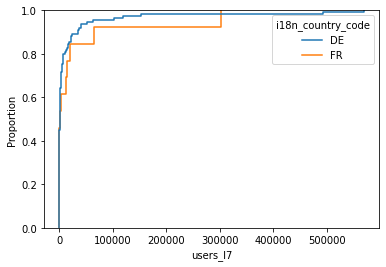

In [67]:
sns.ecdfplot(data=df_ambassador_subs, x="users_l7", hue="i18n_country_code")

<AxesSubplot:xlabel='users_l7', ylabel='Proportion'>

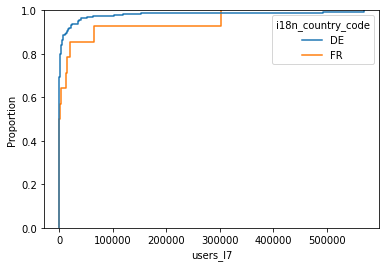

In [68]:
sns.ecdfplot(data=df_ambassador_subs.fillna(0), x="users_l7", hue="i18n_country_code")

<AxesSubplot:xlabel='users_l7', ylabel='Proportion'>

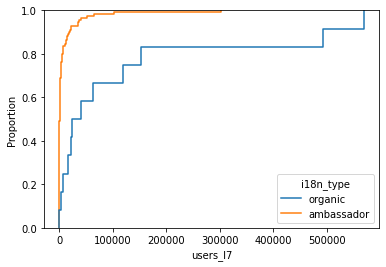

In [69]:
sns.ecdfplot(data=df_ambassador_subs, x="users_l7", hue="i18n_type")

<AxesSubplot:xlabel='users_l7', ylabel='Proportion'>

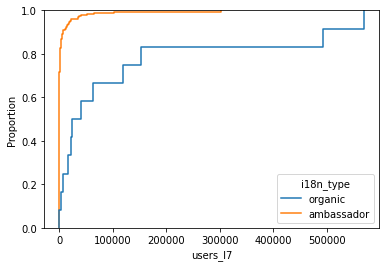

In [70]:
sns.ecdfplot(data=df_ambassador_subs.fillna(0), x="users_l7", hue="i18n_type")

# Appendix

## E) sanity check - language by country

This one helps us check number of posts per country. We see that in most countries the primary post is still English